In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split


In [2]:
train_data_dir = 'X_Train'
colours = os.listdir(train_data_dir)
print(colours)

['Black', 'White']


In [3]:
num_labels = len(colours)

colour_to_label = {
    colour: idx for idx, colour in enumerate(colours)
}

label_to_colour = {
    idx: colour for idx, colour in enumerate(colours)
}

print(num_labels)
print(colour_to_label)
print(label_to_colour)


2
{'Black': 0, 'White': 1}
{0: 'Black', 1: 'White'}


In [4]:
def random_pick() -> tuple[np.ndarray, int]:
    colour = random.choice(colours)
    img_fnames = os.listdir(f'{train_data_dir}/{colour}')
    img_path = f'{train_data_dir}/{colour}/{random.choice(img_fnames)}'

    img = Image.open(img_path).convert('RGB')
    img = np.asarray(img)
    label = colour_to_label[colour]
    return img, label

image_shape=(219, 441, 3)


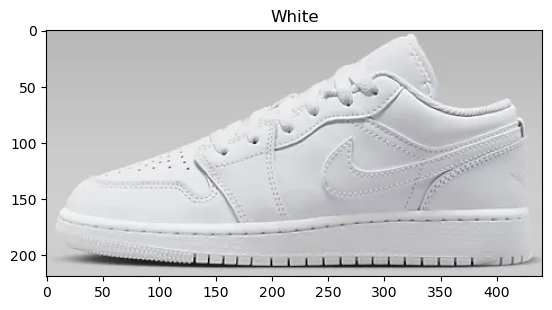

In [5]:
img, label = random_pick()
print(f'image_shape={img.shape}')
plt.imshow(img)
plt.title(label_to_colour[label])
plt.show()

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
class ImageLoader:
    def __init__(self):
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        
    def load(self, img_path):
        img = Image.open(img_path).convert('RGB')
        t_img = self.transform(img)
        return t_img

In [8]:
class ImageDataset(Dataset):

    train_data_dir = 'X_train'

    def __init__ (self, image_loader):
        colours = os.listdir(self.train_data_dir)

        self.data = []

        for colour in tqdm(colours):
            image_fnames = [i for i in os.listdir(f'{self.train_data_dir}/{colour}') if not i.startswith('.')]
            for image_fname in image_fnames:
                img_path = f'{self.train_data_dir}/{colour}/{image_fname}'
                t_img = image_loader.load(img_path)
                label = colour_to_label[colour]
                self.data.append((img_path, t_img, label))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


In [9]:
dataset = ImageDataset(ImageLoader())

100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


In [10]:
dataset[0][1].shape

torch.Size([3, 224, 224])

In [11]:
val_ratio = 0.1
test_size = 10

val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - (val_size + test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # X_train, y_train, ytest



In [12]:
len(dataset)

63

In [13]:
print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 47, val: 6, test: 10


In [14]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_size, shuffle = True)

In [15]:
import torch.nn as nn

In [16]:
class ColorClassifier(nn.Module):
    def __init__(self):
        super(ColorClassifier, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # (224 - 4 + 2 * 1) / 2 + 1 = 112
            nn.MaxPool2d(kernel_size=4, stride=4), # (112 - 4) / 4 + 1 = 28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=1), # (28 - 2 + 2 * 1) / 2 + 1 = 15
            nn.MaxPool2d(kernel_size=3, stride=3), # (15 - 3) / 3 + 1 = 5
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1), # (5 - 2 + 2 * 1) / 1 + 1 = 6
            nn.MaxPool2d(kernel_size=6, stride=1), # (6 - 6) / 1 + 1 = 1
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(256, num_labels)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [17]:
model = ColorClassifier().to(device)

In [18]:
from torchsummary import summary

summary(model, (3, 224, 224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
         MaxPool2d-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
              ReLU-4           [-1, 64, 28, 28]               0
         Dropout2d-5           [-1, 64, 28, 28]               0
            Conv2d-6          [-1, 128, 15, 15]          32,896
         MaxPool2d-7            [-1, 128, 5, 5]               0
       BatchNorm2d-8            [-1, 128, 5, 5]             256
              ReLU-9            [-1, 128, 5, 5]               0
        Dropout2d-10            [-1, 128, 5, 5]               0
           Conv2d-11            [-1, 256, 6, 6]         131,328
        MaxPool2d-12            [-1, 256, 1, 1]               0
      BatchNorm2d-13            [-1, 256, 1, 1]             512
             ReLU-14            [-1, 25

In [19]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [20]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    train_loss, total, corrects = 0, 0, 0
    for _, inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        preds = outputs.argmax(dim=1)
        total += len(inputs)
        corrects += (preds == labels).sum().item()

        loss.backward()
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_accuracy = corrects / total
    
    return train_loss, train_accuracy

def evaluate(model, criterion, data_loader):
    model.eval()
    val_loss, total, corrects = 0, 0, 0
    with torch.no_grad():
        for _, inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            total += len(inputs)
            corrects += (preds == labels).sum().item()
    
    val_loss /= len(data_loader)
    val_accuracy = corrects / total   
    
    return val_loss, val_accuracy

In [21]:
epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, criterion, validation_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'epoch={epoch + 1}, train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, train_accuracy={train_accuracy:.3f}, val_accuracy={val_accuracy:.3f}')

100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch=1, train_loss=0.705, val_loss=0.653, train_accuracy=0.362, val_accuracy=0.667


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


epoch=2, train_loss=0.680, val_loss=0.642, train_accuracy=0.468, val_accuracy=0.667


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


epoch=3, train_loss=0.656, val_loss=0.638, train_accuracy=0.489, val_accuracy=0.667


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch=4, train_loss=0.642, val_loss=0.639, train_accuracy=0.511, val_accuracy=0.667


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch=5, train_loss=0.596, val_loss=0.642, train_accuracy=0.511, val_accuracy=0.667


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch=6, train_loss=0.649, val_loss=0.647, train_accuracy=0.532, val_accuracy=0.667


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch=7, train_loss=0.593, val_loss=0.651, train_accuracy=0.660, val_accuracy=0.833


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

epoch=8, train_loss=0.548, val_loss=0.649, train_accuracy=0.830, val_accuracy=1.000



100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


epoch=9, train_loss=0.535, val_loss=0.643, train_accuracy=0.894, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

epoch=10, train_loss=0.550, val_loss=0.639, train_accuracy=0.851, val_accuracy=1.000



100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


epoch=11, train_loss=0.523, val_loss=0.636, train_accuracy=0.872, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

epoch=12, train_loss=0.501, val_loss=0.633, train_accuracy=0.830, val_accuracy=0.833



100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


epoch=13, train_loss=0.436, val_loss=0.622, train_accuracy=0.830, val_accuracy=0.833


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch=14, train_loss=0.440, val_loss=0.607, train_accuracy=0.894, val_accuracy=0.833


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


epoch=15, train_loss=0.341, val_loss=0.588, train_accuracy=0.872, val_accuracy=0.833


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


epoch=16, train_loss=0.328, val_loss=0.555, train_accuracy=0.872, val_accuracy=0.833


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


epoch=17, train_loss=0.292, val_loss=0.530, train_accuracy=0.936, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

epoch=18, train_loss=0.296, val_loss=0.507, train_accuracy=0.894, val_accuracy=1.000



100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


epoch=19, train_loss=0.332, val_loss=0.482, train_accuracy=0.894, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch=20, train_loss=0.198, val_loss=0.448, train_accuracy=0.957, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch=21, train_loss=0.152, val_loss=0.406, train_accuracy=0.936, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


epoch=22, train_loss=0.186, val_loss=0.364, train_accuracy=0.915, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

epoch=23, train_loss=0.290, val_loss=0.345, train_accuracy=0.872, val_accuracy=1.000



100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch=24, train_loss=0.112, val_loss=0.325, train_accuracy=0.979, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch=25, train_loss=0.192, val_loss=0.291, train_accuracy=0.894, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch=26, train_loss=0.229, val_loss=0.264, train_accuracy=0.872, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch=27, train_loss=0.171, val_loss=0.233, train_accuracy=0.936, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch=28, train_loss=0.083, val_loss=0.204, train_accuracy=1.000, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch=29, train_loss=0.137, val_loss=0.186, train_accuracy=0.957, val_accuracy=1.000


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

epoch=30, train_loss=0.151, val_loss=0.173, train_accuracy=0.936, val_accuracy=1.000


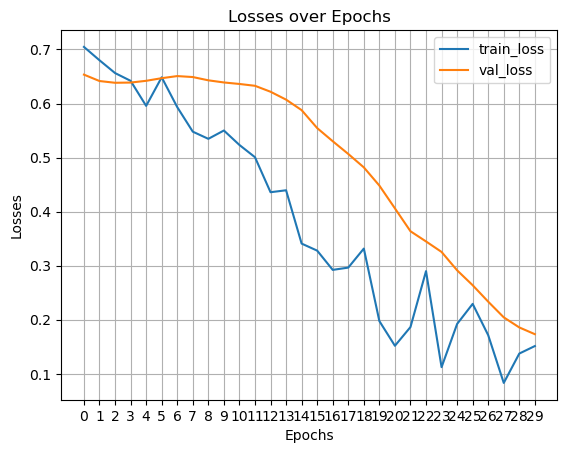

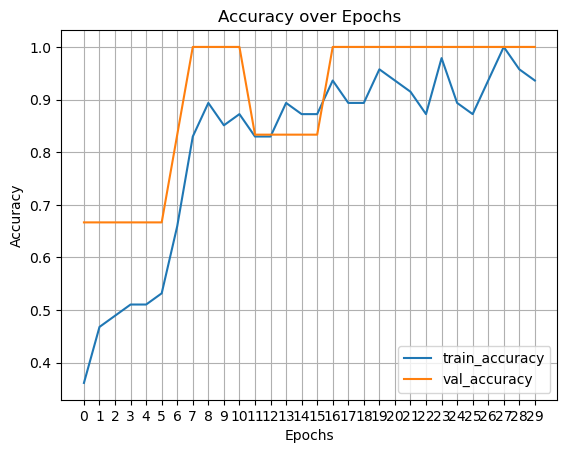

In [22]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), val_losses)
plt.legend(['train_loss', 'val_loss'])
plt.xticks(range(epochs))
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Losses over Epochs')
plt.grid(True)
plt.show()

plt.plot(range(epochs), train_accuracies)
plt.plot(range(epochs), val_accuracies)
plt.legend(['train_accuracy', 'val_accuracy'])
plt.xticks(range(epochs))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.grid(True)
plt.show()

In [23]:
from torch.utils.data import Subset

sample_data = Subset(test_dataset, range(10))
sample_loader = DataLoader(sample_data, batch_size=30)

In [43]:
import math

def plot_images(model, img_paths, t_imgs, labels = None):
    _, axes = plt.subplots(
        math.ceil(len(img_paths) / 5),
        5,
        figsize=(15, 5 * math.ceil(len(img_paths) / 5)),
    )
    plt.tick_params(left=False, right=False, bottom=False)
    outputs = model(t_imgs.to(device))
    outputs = torch.softmax(outputs, dim=1)

    preds = outputs.argmax(1)
    best_indices = outputs.argsort(dim=1, descending=True)

    axes = np.reshape(axes, (math.ceil(len(img_paths) / 5), 5))  # Reshape axes array
    
    for i in range(len(preds)):
        img = Image.open(img_paths[i]).convert('RGB')
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].set_xticks([])
        axes[i // 5, i % 5].set_yticks([])
        
        best_idx0 = best_indices[i][0].item()
        best_idx1 = best_indices[i][1].item()
        title = ''
        if labels is not None:
            title += f'Actual Colour: {label_to_colour[labels[i].item()]}\n'
        title += '-' * 20 + '\n'
        title += f"Predicted {label_to_colour[best_idx0]}: {outputs[i, best_idx0]*100:.2f}%\n"
        title += f"Predicted {label_to_colour[best_idx1]}: {outputs[i, best_idx1]*100:.2f}%\n"
        axes[i // 5, i % 5].set_title(title)

    plt.show()

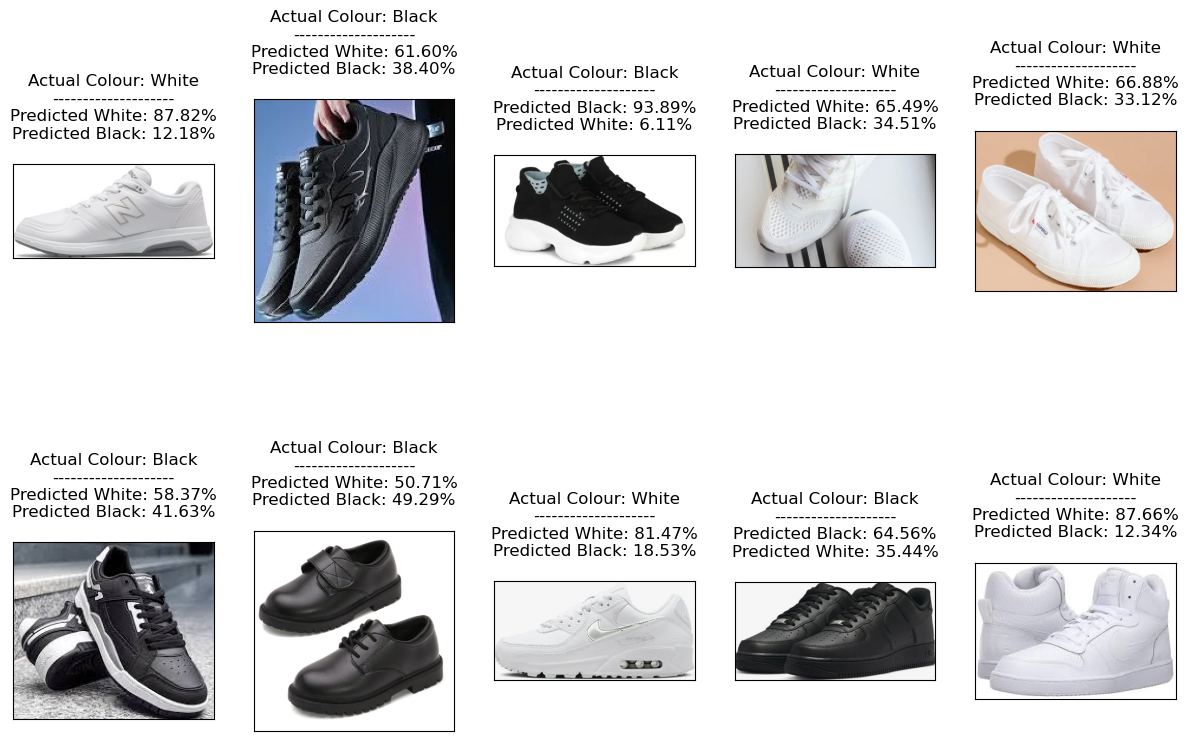

In [44]:
with torch.no_grad():
    for img_paths, t_imgs, labels in test_loader:
        plot_images(model, img_paths, t_imgs, labels)